<a href="https://colab.research.google.com/github/blancavazquez/Taller_NLPWebminar/blob/main/notebook/extraccion_series_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller: Hacia la simulación de la evolución clínica del paciente
## Blanca Hilda Vázquez Gómez

**Objetivo:** Implementar un modelo que permita predecir de manera temprana la evolución clínica del paciente a partir del procesamiento de series de tiempo multivariadas.

**¿Por qué desarrollar modelos para predecir el comportamiento clínico?**

- La detección temprana del deterioro del paciente puede contribuir en reducir tiempos de espera en la administración de tratamientos



**Descripción de la base de datos**

La base de datos de EHR que son usados en esta libreta fueron extraídos del sitio [The PhysioNet/Computing in Cardiology Challenge 2012](https://physionet.org/content/challenge-2012/1.0.0/). Las siguientes características generales de esta base de datos se describe a continuación:

- Cuenta con 12,000 registros de admisiones.
- Las admisiones corresponden a las unidades de cuidados intensivos: cardíacas, médicas, quirúrgicas y traumatológicas.
- Se registraron 42* variables clínicas durante las primeras 48 horas de admisión a la ICU.
- De las 42 variables, 6 son descriptores y fueron recolectados al momento de la admisión, las variables restantes son series de tiempo.


### Extracción y lectura de los EHR

In [ ]:
#Carga de bibliotecas
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
#Extraer los datos a Colab
!git clone https://github.com/blancavazquez/DAMA_EHR19.git

fatal: destination path 'DAMA_EHR19' already exists and is not an empty directory.


In [ ]:
# Carga de los datos
filepath_patients = '/content/DAMA_EHR19/data/set-a_b' #datos
filepath_outcomes = '/content/DAMA_EHR19/data/Outcomes-a_b.csv' # labels

def read_data(filepath):
    """ Función para visualizar el contenido de la base de datos"""
    data = pd.read_csv(filepath)
    return data

#Visualizando el archivo 'Outcomes-a_b.csv'
outcomes = read_data(filepath_outcomes)
print(outcomes.head()) #return the first 5 rows

   RecordID  SAPS-I  SOFA  Length_of_stay  Survival  In-hospital_death
0    132539       6     1               5        -1                  0
1    132540      16     8               8        -1                  0
2    132541      21    11              19        -1                  0
3    132543       7     1               9       575                  0
4    132545      17     2               4       918                  0


In [ ]:
#Visualizando el archivo de un paciente en específico
pat_132539 = read_data('/content/DAMA_EHR19/data/set-a_b/132539.txt')
print(pat_132539.head(10))#regresa las primeras 10 filas

    Time  Parameter      Value
0  00:00   RecordID  132539.00
1  00:00        Age      54.00
2  00:00     Gender       0.00
3  00:00     Height      -1.00
4  00:00    ICUType       4.00
5  00:00     Weight      -1.00
6  00:07        GCS      15.00
7  00:07         HR      73.00
8  00:07  NIDiasABP      65.00
9  00:07      NIMAP      92.33


## Construcción de diccionarios
Vamos a construir unas estructuras de datos (diccionarios) para guardar la información de los pacientes para su posterior procesamiento

In [ ]:
def dict_outcomes(path_outcomes):
    """ Crea un diccionario para extraer las etiquetas de cada paciente" """ 
    with open(path_outcomes) as file:
        input = csv.reader(file)
        next(input) # salta la primera fila y se mueve a la siguiente
        outcomes = defaultdict(list)
        for row in input:
            outcomes[row[0]] = row
        return outcomes

outcomes={}
outcomes = dict_outcomes(filepath_outcomes)

In [ ]:
def read_pat(filepath_patients,icustay):
    """ Crea un diccionario para almacenar los EHR por paciente"""
    data_icu = {}
    for icustay_id in icustay.keys():
        file = '{}.txt'.format(icustay_id)
        f = open(os.path.join(filepath_patients,file))
        read_data = csv.reader(f)
        next(read_data) #salta la primera fila y se mueve a la siguiente
        next(read_data) #salta la fila "recordID"
        data = defaultdict(list)
        for row in read_data:
            data[row[1]].append((row[0],row[2]))
            data_icu[icustay_id] = data
    return data_icu

data_icu = read_pat(filepath_patients,outcomes) #salida: 'BUN': [('10:37', '13'), ('33:07', '8')]

### Análisis de datos
A partir de las estructuradas creadas previamente, procedemos a analizar cada variable clínica

In [ ]:
vars_estaticas = ['Age', 'Gender', 'Height', 'ICUType']
vars_dinamicas = ['Albumin','ALP','ALT','AST','Bilirubin','BUN','Cholesterol',
                'Creatinine','DiasABP','FiO2','GCS','Glucose','HCO3',
                'HCT','HR','K','Lactate','Mg','MAP','MechVent',
                'Na','NIDiasABP','NIMAP','NISysABP','PaCO2',
                'PaO2','pH','Platelets','RespRate','SaO2',
                'SysABP','Temp','TroponinI','TroponinT','WBC','Weight'] 
    
def analysis_data(data):
    """ Función para extraer los datos de cada variable clínica """
    features = {} #Creamos un diccionario vacío
    values_features = {}
    for name in vars_estaticas:
        valor = float(data[name][0][1])
        if valor < 0: #si en las variables estáticas, el valor no fue registrado, entonces colocamos NAN
            features[name] = np.nan
        else:
            features[name] = float(data[name][0][1])
    for name in vars_dinamicas:
        if name in data:
            values = [float(d[1]) for d in data[name]]
            if valor < 0: #si en las variables dinámicas, el valor no fue registrado, entonces colocamos NAN
                features[name] = np.nan
            else:
                values_features[name] = values
        features.update(values_features)
    return features

obtain_features = [] #creación de una lista vacía
labels = []
ids = []
for id, data in data_icu.items(): #retorna una copia del diccionario
    features = analysis_data(data) ## Servirá para el analisis de los datos
    obtain_features.append(features)
    labels.append(outcomes[id][5]) # recuperamos la etiqueta "In-hospital_death"
    ids.append(id)
      
#Convertimos el diccionario a dataFrame para poder visualizar la distribución de los datos
obtain_features = pd.DataFrame(obtain_features)
labels = pd.DataFrame(labels, columns = ['hospital_death'])
pd_data = pd.concat([obtain_features, labels], axis = 1, sort = False) #concatenamos variables + label

In [ ]:
pd_data.head(1)

,Age,Gender,Height,ICUType,BUN,Creatinine,GCS,Glucose,HCO3,HCT,...,Albumin,ALP,ALT,AST,Bilirubin,Lactate,Cholesterol,TroponinI,TroponinT,hospital_death
0,54.0,0.0,NaN,4.0,"[13.0, 8.0]","[0.8, 0.7]","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....","[205.0, 115.0]","[26.0, 28.0]","[33.7, 33.5, 30.3]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Uno de los pasos más importantes, antes de la construcción de cualquier modelo, es explorar nuestros datos. Esto consiste en conocer sus distribuciones, analizar si existen datos faltantes, identificar datos capturados de manera errónea, si se usaron las mismas escalas de medición, entre otros.

Text(0, 0.5, 'Número de pacientes')

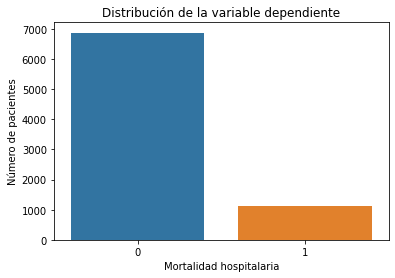

In [ ]:
#Visualizamos los datos!
plt.title('Distribución de la variable dependiente')
sns.countplot(x="hospital_death", data=pd_data)
plt.xlabel('Mortalidad hospitalaria')
plt.ylabel('Número de pacientes')

In [ ]:
print(pd_data['hospital_death'].value_counts()) #Explorando el total de registros (0:death, 1:survived)

0    6878
1    1122
Name: hospital_death, dtype: int64


Text(0, 0.5, 'Frecuencia')

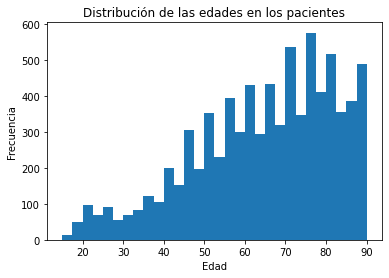

In [ ]:
plt.title("Distribución de las edades en los pacientes")
plt.hist(pd_data['Age'], bins = 30)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

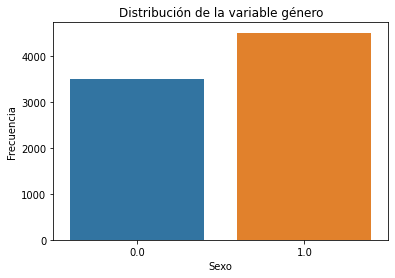

In [ ]:
sns.countplot(x="Gender", data=pd_data) #0: femenino, 1: masculino
plt.title('Distribución de la variable género')
plt.xlabel('Sexo')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

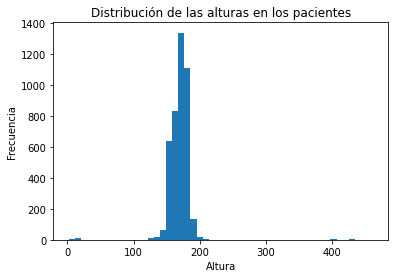

In [ ]:
plt.title("Distribución de las alturas en los pacientes")
plt.hist(pd_data['Height'], bins = 50)
plt.xlabel('Altura')
plt.ylabel('Frecuencia')

### Analizando la tasa de ausencia por variable clínica

In [ ]:
missing_values_count = pd_data.isnull().sum() #isnull detecta valores ausentes en los registros
dict = {}
dict = missing_values_count

<BarContainer object of 21 artists>

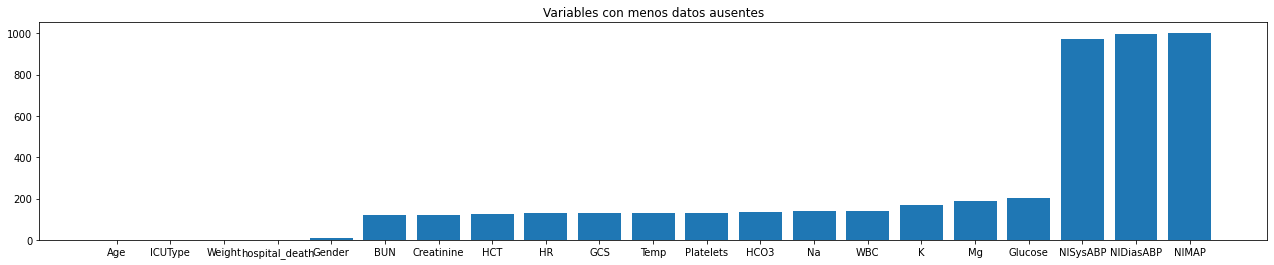

In [ ]:
list = sorted(dict.items(), key = lambda x : x[1])
vars_menos_ausentes = list[:21]

plt.figure(figsize=(22,4))
plt.title("Variables con menos datos ausentes")
x, y = zip(*vars_menos_ausentes)
plt.bar(x, y)

<BarContainer object of 20 artists>

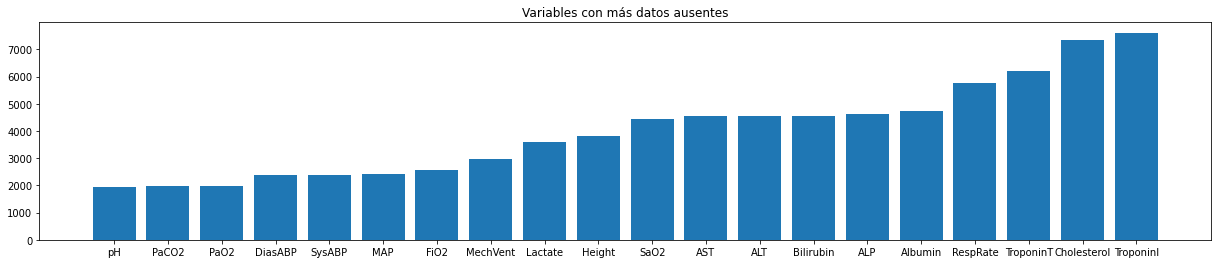

In [ ]:
list = sorted(dict.items(), key = lambda x : x[1])
vars_mas_ausentes = list[21:]

plt.figure(figsize=(21,4))
plt.title("Variables con más datos ausentes")
x, y = zip(*vars_mas_ausentes)
plt.bar(x, y)

#### Hallazgos en el análisis de datos:

- De las 42 variables disponibles, las variables con la mayor tasa de ausencia son RespRate,TroponinT, Cholesterol y Troponin I
    - ¿Qué debemos hacer: mantener todas las variables o descartar aquellas con tasa de ausencia muy alta?
- En relación a la distribución de la población, tenemos que 6,878 (85.97%) pacientes sobrevivieron después de estar en una ICU, mientras que 1,122 (14.02%) pacientes no sobrevivieron.
    - Si construimos un modelo con esta distribución ¿creen que el modelo tendrá un buen rendimiento para predecir mortalidad?
- Se observó que hay diferentes escalas de medición entre las características. Por ejemplo, la edad está dada en años, mientras que el ritmo cardiaco (HR) está dado en bpm (latidos por minuto). Esta diferencia de escalas puede generar que se de más importancia a algunas variables frente a otras. 
    - Por tal motivo, escalaremos los datos, es decir, unificaremos la escala para todas las características, de manera que no influya algunas características en relación a otras.
- Se observó errores al momento de la captura de los datos, por ejemplo, existen casos que se registró: 1.8 para referirse a 180cm o casos que se registró: 81.8 inch para referirse a 180cm

### Extracción de series de tiempo
El rendimiento de los modelos dependen en gran medida de la calidad de los datos. Para cada una de las variables dinámicas se extraen sus respectivas series de tiempo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
variables_dinamicas = ['BUN','Creatinine','HCT','HR','GCS','Temp','Platelets','HCO3','Na','WBC','K','Mg','Glucose']
columns = ['Pid','BUN','Creatinine','HCT','HR','GCS','Temp','Platelets','HCO3','Na','WBC','K','Mg','Glucose']

def extraccion_label(id):
    return outcomes[id][5]

def extraccion_demo(id,data):
    """ Función para extraer datos demográficos de los pacientes """
    pre_features = {}
    vars_estaticas_less = ['Age', 'ICUType', 'Gender','Height']

    pre_features = {'Pid':id,'Mortality':extraccion_label(id)} #añadimos la etiqueta

    for name in vars_estaticas_less:
        valor = float(data[name][0][1])
        if valor < 0: #si en las variables estáticas, el valor no fue registrado, entonces colocamos NAN
            pre_features[name] = np.nan
        elif name == "Age" and valor > 90:#Para ajustar el rango de edades
            pre_features[name] = 91.4 #aquellas edades mayores a 90, las reemplazamos a 91.4 (HIPAA)
        elif name == "Height" and valor < 10:
            pre_features[name] = valor * 100 #existen casos que se registró: 1.8 para referirse a 180cm
        elif name == "Height" and valor < 25:
            pre_features[name] = valor * 10 #existen casos que se registró: 18 para referirse a 180cm
        elif name == "Height" and valor < 100:
            pre_features[name] = valor * 2.2 #existen casos que se registró: 81.8 inch para referirse a 180cm
        elif name == "Height" and valor > 1000:
            pre_features[name] = valor * 0.1 #existen casos que se registró: 1800 para referirse a 180cm
        elif name == "Height" and valor > 250:
            pre_features[name] = valor * 0.3937 #existen casos que se registró: 400 para referirse a 157cm
        else:
            pre_features[name] = float(data[name][0][1])
    return pre_features

def extraccion_series_tiempo(id,data):
    """ Función para extraer las series de tiempo por paciente"""
    df = pd.DataFrame(columns=columns) #dataframe para guardar las series

    # --- Extracción de datos demográficos ---
    demo = extraccion_demo(id,data)
    demo = pd.DataFrame(demo,index=[0])

    for parameter in variables_dinamicas: #'Temp': [('00:21', '36.3'), ('03:36', '36.4')],
        if parameter in data: 
          hora = [d[0] for d in data[parameter]]
          ehr = [float(d[1]) for d in data[parameter]]
          if not ehr:
            temporales = pd.DataFrame({'Pid':id,parameter:np.nan},index=[0])
          else:
            for pos in range(len(hora)):
              temporales = pd.DataFrame({'Pid':id,parameter:ehr[pos]},index=[str(hora[pos])])
              df = pd.concat([df, temporales], axis=0) #concatenando valores, mantiene nans

    df["Pid"] = pd.to_numeric(df["Pid"]) #convertir columna de 'object'--> numeric
    df.reset_index(inplace=True)
    out = df.groupby(by=['index','Pid'], dropna=False).sum(min_count=1) #mantiene los NAN values
    out.reset_index(inplace=True)
    out.rename(columns={'index':'offset'},inplace=True) #renombramos la columna como offset
    return out, demo

def preprocessing(data_icu):
    df_series_tiempo = pd.DataFrame(columns=['Pid','time','BUN','Creatinine','HCT','HR','GCS','Temp','Platelets','HCO3','Na','WBC','K','Mg','Glucose'])
    df_demo = pd.DataFrame(columns=['Pid','Mortality','Age','ICUType','Gender','Height'])

    pat = 0
    for id, data in data_icu.items(): # retorna una copia del diccionario
        series,demo = extraccion_series_tiempo(id,data)
        series = agrupar_features_per_hour(id,series) #promediar las mediciones por hora

        if series.shape[0] == 48: #Añadir pacientes que 48 mediciones (1 medición por hora)     
          df_demo = pd.concat([df_demo, demo], axis=0) #concatenando demo
          df_series_tiempo = pd.concat([df_series_tiempo, series], axis=0) #concatenando series

        # ----Only for testing ----#
        #if pat > 2:
          #break
        #else:
          #pat +=1
        #----------------------#

    df_series_tiempo.sort_values(by=['Pid','time'],inplace=True)
    return df_series_tiempo, df_demo

def agrupar_features_per_hour(id,serie_tiempo):
    """ ---Agrupando series de tiempo --- """ 
    serie_tiempo['time'] = [x + ':00' for x in serie_tiempo['offset']]
    serie_tiempo['time'] = pd.to_timedelta(serie_tiempo['time'])
    serie_tiempo = serie_tiempo.set_index('time')
    serie_tiempo = serie_tiempo.resample('H').mean() #Por hora, se promedian los valores por cada variable
    serie_tiempo['Pid'] = id
    serie_tiempo.reset_index(inplace=True)
    return serie_tiempo

df_series_tiempo,df_demo = preprocessing(data_icu)

#Renombrar columnas
df_demo.rename(columns={'Mortality':'Mortalidad','Age':'Edad','ICUType':'TipoICU','Gender':'Sexo','Height':'Altura'}, inplace=True)

In [ ]:
print("Tamaño de las series de tiempo:", df_series_tiempo.shape)
print("Tamaño de los datos demográficos:", df_demo.shape)

Tamaño de las series de tiempo: (165600, 15)
Tamaño de los datos demográficos: (3450, 6)


In [ ]:
df_series_tiempo.to_csv("/content/drive/MyDrive/Colab Notebooks/Taller_NLPWebminar/data/df_series_tiempo_webminar.csv")
df_demo.to_csv("/content/drive/MyDrive/Colab Notebooks/Taller_NLPWebminar/data/df_demo_webinar.csv")